# The Kalman filter

The model below is taken from the [paper](https://link.springer.com/content/pdf/10.1007/s11222-019-09884-y.pdf), Section 5.3 with simplifications.

Consider the following hidden Markov model:
\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0), \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A x_{t-1}, Q), \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R).
\end{align*}

We can also write this model as $X_0 \sim \pi_0$ and
\begin{align*}
X_t = A X_{t-1} + Q^{1/2} \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, I), \\
Y_t = H X_t + R^{1/2} \eta_t, \quad \eta_t \sim \mathcal{N}(0, I).
\end{align*}
In this specific example, we have
\begin{align*}
A =
\begin{bmatrix}
I_2 & \kappa I_2 \\
\mathbf{0}_2 & 0.99 I_2
\end{bmatrix}
\end{align*}
where:
- $I_2$ is the $2 \times 2$ identity matrix,
- $\mathbf{0}_2$ is the $2 \times 2$ zero matrix,
- $\kappa = 0.04$.

We have in our model
\begin{align*}
Q =
\begin{bmatrix}
\frac{\kappa^3}{3} I_2 & \frac{\kappa^2}{2} I_2 \\
\frac{\kappa^2}{2} I_2 & \kappa I_2
\end{bmatrix}
\end{align*}
Next, we have
\begin{align*}
H =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
\end{align*}
and finally,
\begin{align*}
R =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}.
\end{align*}

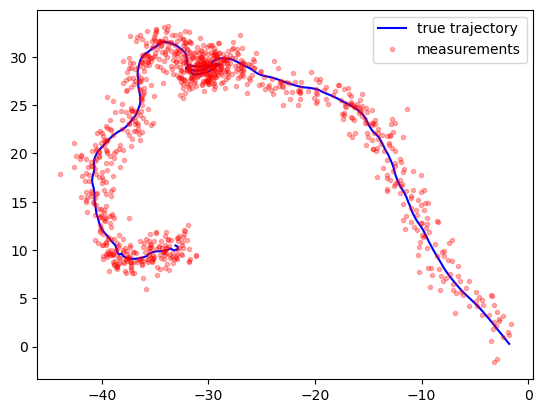

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1234)

# define the linear system for object tracking
# x = [x, y, vx, vy]
T = 1000
x = np.zeros((4, T))
x[:, 0] = np.zeros(4)

kappa = 0.04

# A is a matrix 4x4 matris
# [I_2, kappa*I_2;
# 0_2, 0.99 * I_2]

A = np.block([
    [np.eye(2), kappa * np.eye(2)],
    [np.zeros((2, 2)), 0.99 * np.eye(2)]
])

Q = np.block([
    [kappa**3 / 3 * np.eye(2), kappa**2 / 2 * np.eye(2)],
    [kappa**2 / 2 * np.eye(2), kappa * np.eye(2)]
])

H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])

R = 1 * np.array([[1, 0.0], [0.0, 1]])
m_0 = np.array([0, 0, -5, 5])
P_0 = np.eye(4)

y = np.zeros((2, T))

# Generate the first state:
x0 = rng.multivariate_normal(m_0, P_0)
x[:, 0] = A.dot(x0) + rng.multivariate_normal(np.zeros(4), Q)
y[:, 0] = H.dot(x[:, 0]) + rng.multivariate_normal(np.zeros(2), R)

for t in range(1, T):
    x[:, t] = A.dot(x[:, t-1]) + rng.multivariate_normal(np.zeros(4), Q)
    y[:, t] = H.dot(x[:, t]) + rng.multivariate_normal(np.zeros(2), R)

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.legend(['true trajectory', 'measurements'])


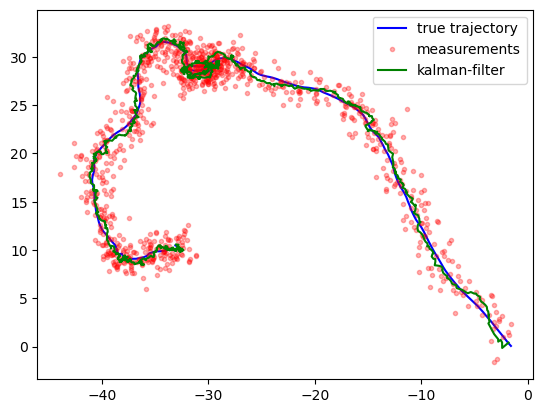

In [13]:
m = np.zeros((4, T))
P = np.zeros((4, 4, T))

m_pred = np.zeros((4, T))
P_pred = np.zeros((4, 4, T))

# Filter the first time point

m_pred[:, 0] = A.dot(m_0)
P_pred[:, :, 0] = A.dot(P_0).dot(A.T) + Q

S = H.dot(P_pred[:, :, 0]).dot(H.T) + R
K = P_pred[:, :, 0].dot(H.T).dot(np.linalg.inv(S))

m[:, 0] = m_pred[:, 0] + K.dot(y[:, 0] - H.dot(m_pred[:, 0]))
P[:, :, 0] = P_pred[:, :, 0] - K.dot(H).dot(P_pred[:, :, 0])

for t in range(1, T):
    m_pred[:, t] = A.dot(m[:, t-1])
    P_pred[:, :, t] = A.dot(P[:, :, t-1]).dot(A.T) + Q

    S = H.dot(P_pred[:, :, t]).dot(H.T) + R
    K = P_pred[:, :, t].dot(H.T).dot(np.linalg.inv(S))

    m[:, t] = m_pred[:, t] + K.dot(y[:, t] - H.dot(m_pred[:, t]))
    P[:, :, t] = P_pred[:, :, t] - K.dot(H).dot(P_pred[:, :, t])

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.plot(m[0, :], m[1, :], 'g-')
plt.legend(['true trajectory', 'measurements', 'kalman-filter'])
plt.show()

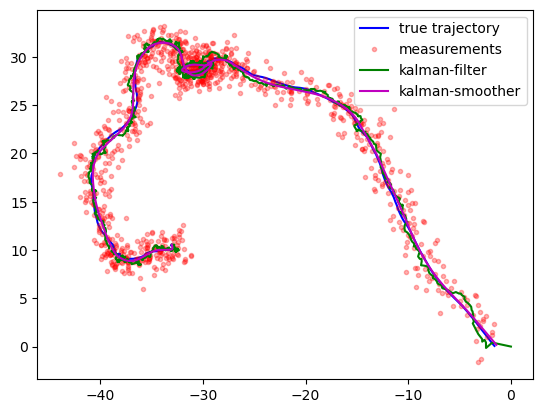

In [14]:
# Kalman smoother
m_smooth = np.zeros((4, T))
P_smooth = np.zeros((4, 4, T))

m_smooth[:, -1] = m[:, -1]
P_smooth[:, :, -1] = P[:, :, -1]

for t in range(T-2, -1, -1):
    J = P[:, :, t].dot(A.T).dot(np.linalg.inv(P_pred[:, :, t+1]))
    m_smooth[:, t] = m[:, t] + J.dot(m_smooth[:, t+1] - m_pred[:, t+1])
    P_smooth[:, :, t] = P[:, :, t] + (J.dot(P_smooth[:, :, t+1] - P_pred[:, :, t+1])).dot(J.T)

J = P_0.dot(A.T).dot(np.linalg.inv(P_pred[:, :, 0]))
m_smooth_0 = m_0 + J.dot(m_smooth[:, 0] - m_pred[:, 0])
P_smooth_0 = P_0 + J.dot(P_smooth[:, :, 0] - P_pred[:, :, 0]).dot(J.T)

# concatenate x0 and x
x = np.concatenate([x0[:, np.newaxis], x], axis=1)
m_smooth = np.concatenate([m_smooth_0[:, np.newaxis], m_smooth], axis=1)
m = np.concatenate([m_0[:, np.newaxis], m], axis=1)

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.plot(m[0, :], m[1, :], 'g-')
plt.plot(m_smooth[0, :], m_smooth[1, :], 'm-')
plt.legend(['true trajectory', 'measurements', 'kalman-filter', 'kalman-smoother'])
plt.show()
